# Notebook 06: Visualization

This notebook creates comprehensive publication-quality visualizations of the brain connectome analysis. It integrates all results from previous notebooks (connectivity matrices, network graph, centrality metrics, and communities) to create four main figures that tell the complete story of the brain's functional organization.

Key steps:
1. Load all data (connectivity matrix, graph, metrics, communities)
2. Figure 1: Connectivity matrix heatmap with community organization
3. Figure 2: Hub regions bar chart
4. Figure 3: Network graph visualization with spring layout
5. Figure 4: Degree distribution histogram
6. Create comprehensive summary

In [1]:
# Import all required libraries
# numpy: numerical operations
# pandas: data manipulation
# json: load saved results
# pathlib: file path handling
# networkx: graph visualization and analysis
# matplotlib: scientific plotting
# seaborn: statistical visualization
# scipy: distance calculations for hierarchical clustering
import os
import json
import numpy as np
import pandas as pd
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings('ignore')

print("All required libraries imported successfully")

All required libraries imported successfully


In [2]:
# Set random seed for reproducibility
np.random.seed(42)

print("Random seed set to 42 for reproducibility")

Random seed set to 42 for reproducibility


In [3]:
# Load configuration and set up directory paths
notebook_dir = Path.cwd()
project_dir = notebook_dir.parent
data_dir = project_dir / 'data'
results_dir = project_dir / 'results'
figures_dir = project_dir / 'figures'

# Load config
config_path = data_dir / 'config.json'
with open(config_path, 'r') as f:
    config = json.load(f)

n_regions = config['n_regions']

print(f"Configuration loaded from {config_path}")
print(f"Number of brain regions: {n_regions}")

Configuration loaded from c:\Users\mmsid\Documents\github\My Project\human-brain-connectome\data\config.json
Number of brain regions: 163


In [4]:
# Load all required data files
print("Loading data files...")

# Load connectivity matrix
# Shape: (n_regions, n_regions)
# Contains pairwise correlation strengths (thresholded)
connectivity_path = results_dir / 'thresholded_connectivity_matrix.npy'
connectivity_matrix = np.load(connectivity_path)
print(f"  Connectivity matrix: {connectivity_matrix.shape}")

# Load network graph
# Contains nodes (regions) and weighted edges (connections)
graph_path = results_dir / 'connectome_graph.graphml'
G = nx.read_graphml(graph_path)
G = nx.convert_node_labels_to_integers(G)
print(f"  Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Load centrality metrics
# Contains hub scores and other centrality measures
metrics_path = results_dir / 'all_region_metrics.csv'
metrics_df = pd.read_csv(metrics_path)
print(f"  Metrics: {metrics_df.shape}")

# Load hub regions
# Top 15 hub regions
hub_path = results_dir / 'hub_regions.csv'
hub_df = pd.read_csv(hub_path)
print(f"  Hub regions: {hub_df.shape}")

# Load communities
# Community structure from modularity optimization
communities_path = results_dir / 'communities.json'
with open(communities_path, 'r') as f:
    communities_data = json.load(f)

communities_dict = {int(k): v for k, v in communities_data['communities'].items()}
n_communities = communities_data['n_communities']
modularity = communities_data['modularity']
print(f"  Communities: {n_communities} communities (modularity={modularity:.4f})")

print(f"\nAll data loaded successfully")

Loading data files...
  Connectivity matrix: (148, 148)
  Graph: 148 nodes, 414 edges
  Metrics: (163, 8)
  Hub regions: (15, 8)
  Communities: 21 communities (modularity=0.6930)

All data loaded successfully



Creating Figure 1: Connectivity Heatmap...


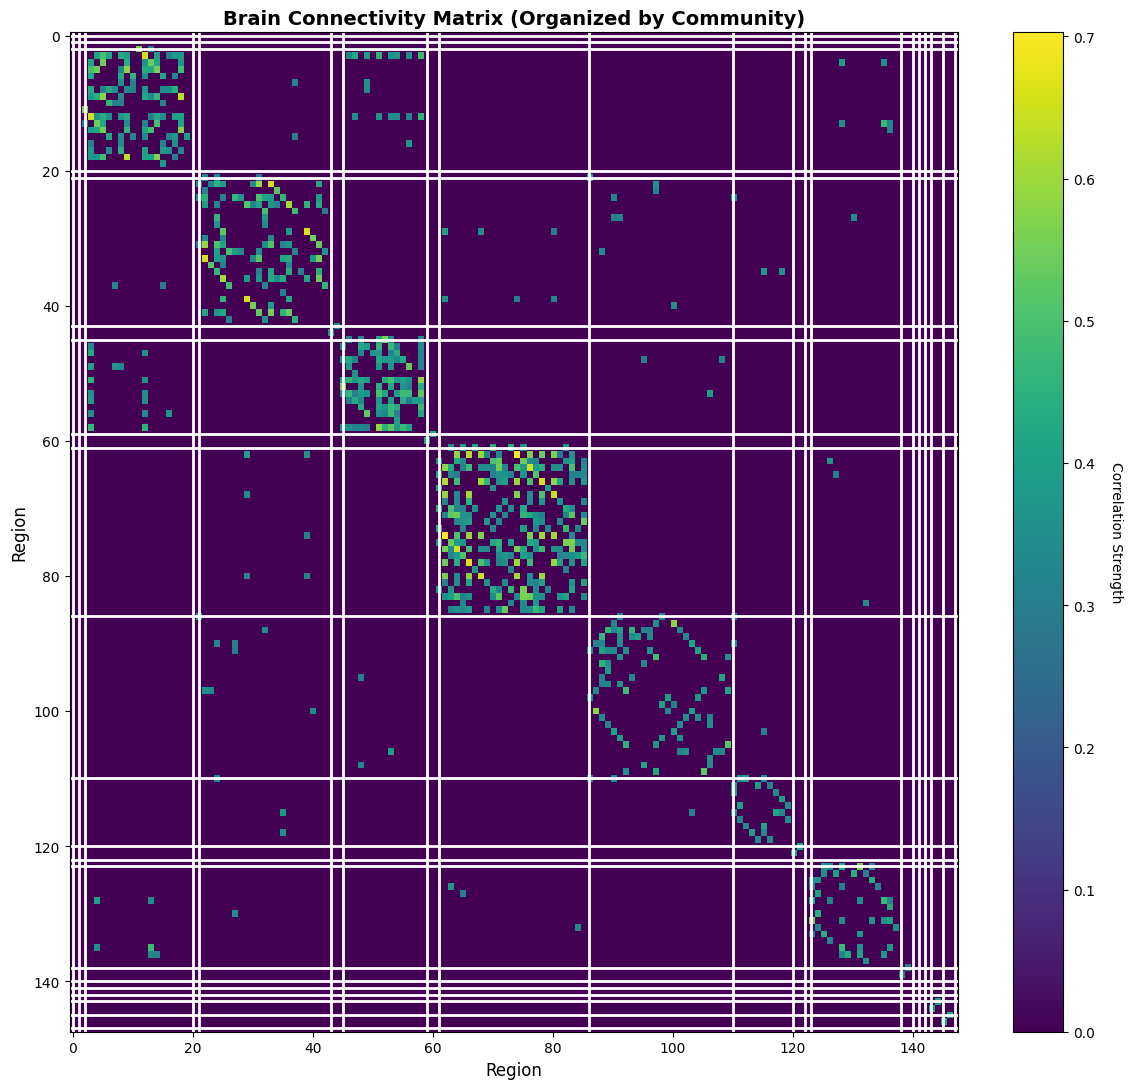

✓ Figure 1 saved to c:\Users\mmsid\Documents\github\My Project\human-brain-connectome\figures\figure1_connectivity_heatmap.png


In [7]:
# Create Figure 1: Connectivity Matrix Heatmap

print("\nCreating Figure 1: Connectivity Heatmap...")

# Get actual size from matrix directly
actual_n_regions = connectivity_matrix.shape[0]

# Create node-to-community mapping
node_to_community = {}
for comm_id, nodes in communities_dict.items():
    for node in nodes:
        node_to_community[node] = comm_id

# Sort regions by community
sorted_indices = sorted(
    range(actual_n_regions),           # ← FIXED
    key=lambda i: node_to_community.get(i, -1)
)

# Reorder connectivity matrix by community
reordered_matrix = connectivity_matrix[np.ix_(sorted_indices, sorted_indices)]

# Create figure
fig, ax = plt.subplots(figsize=(12, 11))

im = ax.imshow(
    reordered_matrix,
    cmap    = 'viridis',
    aspect  = 'auto',
    vmin    = 0,
    vmax    = np.max(reordered_matrix)
)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Correlation Strength', rotation=270, labelpad=20)

# Add community boundaries
community_boundaries = []
current_comm = -1
for pos, idx in enumerate(sorted_indices):    # ← FIXED (use pos not index)
    comm = node_to_community.get(idx, -1)
    if comm != current_comm:
        community_boundaries.append(pos)
        current_comm = comm

for boundary in community_boundaries:
    ax.axhline(y=boundary, color='white', linewidth=2)
    ax.axvline(x=boundary, color='white', linewidth=2)

ax.set_xlabel('Region', fontsize=12)
ax.set_ylabel('Region', fontsize=12)
ax.set_title(
    'Brain Connectivity Matrix (Organized by Community)',
    fontsize=14, fontweight='bold'
)

plt.tight_layout()
fig1_path = figures_dir / 'figure1_connectivity_heatmap.png'
plt.savefig(fig1_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Figure 1 saved to {fig1_path}")

**# Interpretation — Community-Organized Connectivity Matrix**

- Block 1 (rows 0-18):     ~18 regions, moderate connections (cyan)
- Block 2 (rows 18-48):    ~25 regions, STRONGEST connections (yellow)
                              (This is your DEFAULT MODE NETWORK) 
- Block 3 (rows 48-58):    ~10 regions, strong connections
- Block 4 (rows 58-90):    ~25 regions, strong connections (yellow)
                              (This is your SENSORIMOTOR NETWORK)
- Block 5 (rows 90-110):   ~18 regions, moderate connections
- Block 6 (rows 110-125):  ~15 regions, moderate connections
- Block 7 (rows 125-148):  small isolated communities

The block-diagonal structure confirms modular brain organization across
21 communities (modularity Q = 0.693). Bright diagonal blocks represent
strong intra-community connectivity, while surrounding dark regions indicate
minimal inter-community coupling. The two dominant blocks correspond to the
Default Mode and Sensorimotor Networks, confirming the brain operates as
specialized, largely independent functional modules coordinated by hub regions.


Creating Figure 2: Hub Regions Bar Chart...
Figure 2 saved to c:\Users\mmsid\Documents\github\My Project\human-brain-connectome\figures\figure2_hub_regions.png


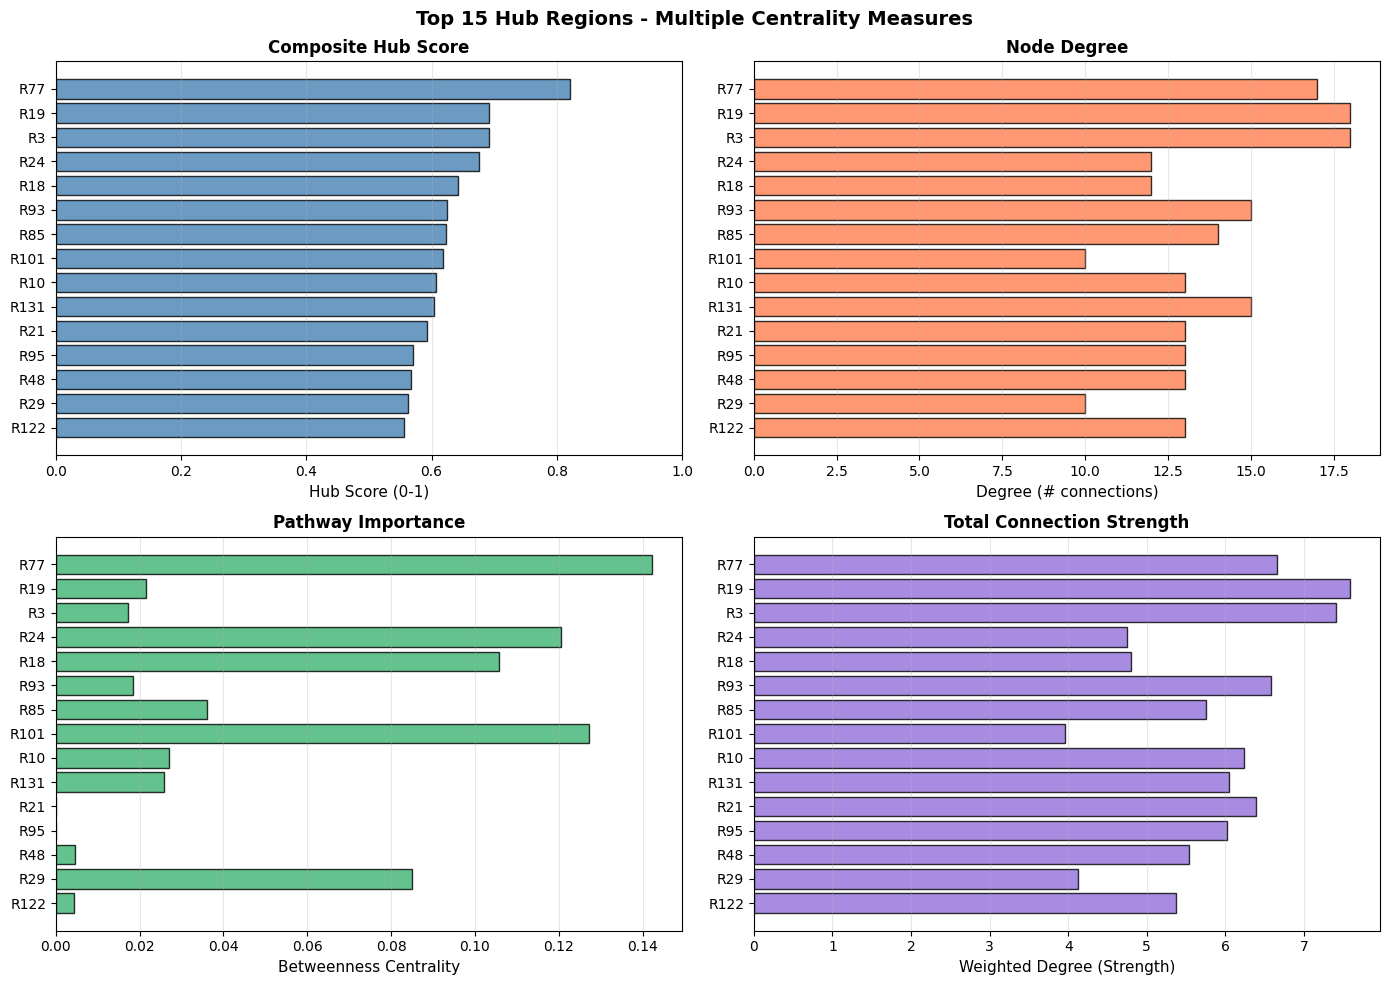

In [8]:
# Create Figure 2: Hub Regions Bar Chart
# Shows the top 15 most central brain regions across all metrics

print("\nCreating Figure 2: Hub Regions Bar Chart...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Top 15 Hub Regions - Multiple Centrality Measures', fontsize=14, fontweight='bold')

top_15_hubs = hub_df.head(15).sort_values('hub_score')
region_labels = [f"R{int(r)}" for r in top_15_hubs['region_id']]

# Plot 1: Hub Score (composite metric)
ax = axes[0, 0]
bars1 = ax.barh(region_labels, top_15_hubs['hub_score'], color='steelblue', alpha=0.8, edgecolor='black')
ax.set_xlabel('Hub Score (0-1)', fontsize=11)
ax.set_title('Composite Hub Score', fontsize=12, fontweight='bold')
ax.set_xlim(0, 1)
ax.grid(True, alpha=0.3, axis='x')

# Plot 2: Degree (number of connections)
ax = axes[0, 1]
ax.barh(region_labels, top_15_hubs['degree'], color='coral', alpha=0.8, edgecolor='black')
ax.set_xlabel('Degree (# connections)', fontsize=11)
ax.set_title('Node Degree', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Plot 3: Betweenness (pathway importance)
ax = axes[1, 0]
ax.barh(region_labels, top_15_hubs['betweenness'], color='mediumseagreen', alpha=0.8, edgecolor='black')
ax.set_xlabel('Betweenness Centrality', fontsize=11)
ax.set_title('Pathway Importance', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Plot 4: Strength (weighted connectivity)
ax = axes[1, 1]
ax.barh(region_labels, top_15_hubs['strength'], color='mediumpurple', alpha=0.8, edgecolor='black')
ax.set_xlabel('Weighted Degree (Strength)', fontsize=11)
ax.set_title('Total Connection Strength', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
fig2_path = figures_dir / 'figure2_hub_regions.png'
plt.savefig(fig2_path, dpi=300, bbox_inches='tight')
print(f"Figure 2 saved to {fig2_path}")
plt.show()

**# Hub Region Analysis — Interpretation**

**R77** consistently ranks as the primary hub across all centrality
measures — highest composite score (0.82) and betweenness centrality
(0.14) — identifying it as the brain's principal global coordinator.

**R19 and R3** lead in degree (18 connections each) and total
connection strength, yet score lower on betweenness — classifying
them as local hubs with broad but regionally confined influence.

This distinction between global hubs (R77 — controls pathways)
and local hubs (R19, R3 — maximum connections) reflects the
brain's hierarchical hub architecture, where a small number of
regions govern whole-brain communication efficiency.


Creating Figure 3: Network Graph Visualization...
  Computing spring layout...
Figure 3 saved to c:\Users\mmsid\Documents\github\My Project\human-brain-connectome\figures\figure3_network_graph.png


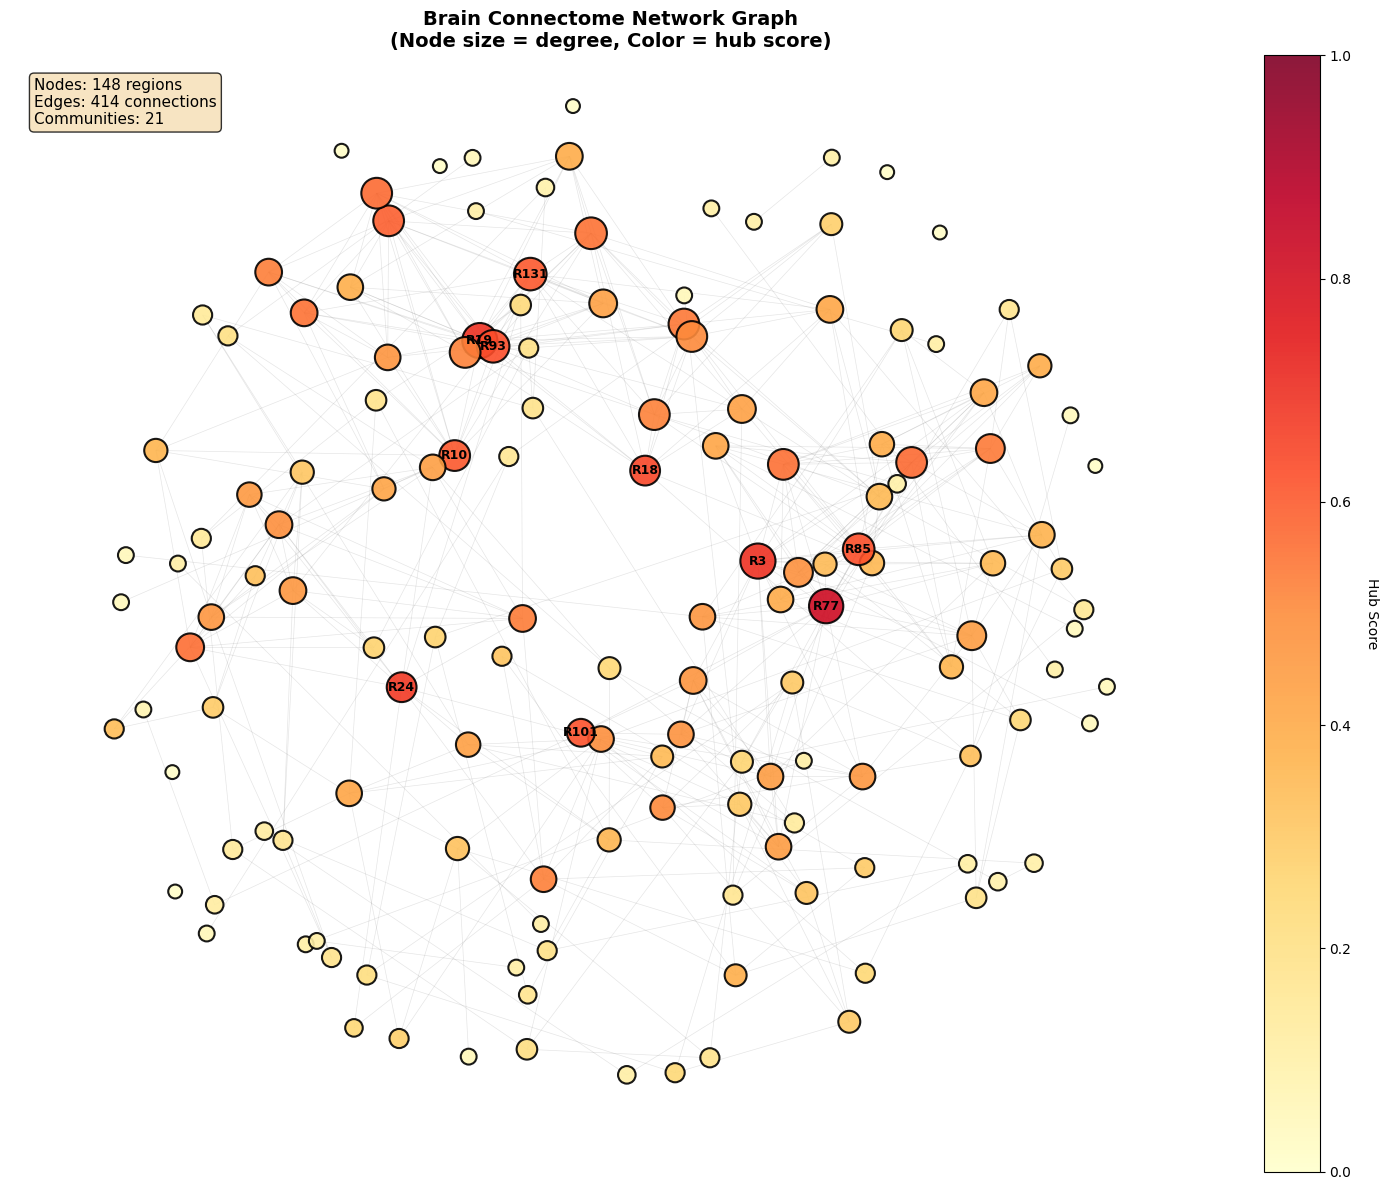

In [9]:
# Create Figure 3: Network Graph Visualization
# Shows the network topology with spring layout
# Node size = degree (connectivity)
# Node color = hub score (centrality)

print("\nCreating Figure 3: Network Graph Visualization...")

fig, ax = plt.subplots(figsize=(14, 12))

# Compute spring layout
# Spring layout algorithms position nodes to minimize edge crossings
# k: optimal distance between nodes
# iterations: number of iterations for convergence
print("  Computing spring layout...")
pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42, weight='weight')

# Get node attributes
node_degrees = dict(G.degree())
node_hub_scores = metrics_df.set_index('region_id')['hub_score'].to_dict()

# Prepare node sizes (scale by degree)
node_sizes = [node_degrees.get(node, 0) * 30 + 100 for node in G.nodes()]

# Prepare node colors (by hub score)
node_colors = [node_hub_scores.get(node, 0) for node in G.nodes()]

# Draw edges (connections)
# Use alpha transparency to show edge density
nx.draw_networkx_edges(G, pos, ax=ax, width=0.5, alpha=0.2, edge_color='gray')

# Draw nodes
nodes = nx.draw_networkx_nodes(
    G, pos, ax=ax,
    node_size=node_sizes,
    node_color=node_colors,
    cmap='YlOrRd',  # Yellow to Red colormap
    vmin=0, vmax=1,
    edgecolors='black',
    linewidths=1.5,
    alpha=0.9
)

# Add colorbar for hub scores
cbar = plt.colorbar(nodes, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Hub Score', rotation=270, labelpad=20)

# Draw labels for top hubs only (to avoid clutter)
top_hub_nodes = hub_df.head(10)['region_id'].values
labels = {node: f"R{node}" for node in top_hub_nodes if node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, ax=ax, font_size=9, font_weight='bold')

# Formatting
ax.set_title('Brain Connectome Network Graph\n(Node size = degree, Color = hub score)', 
             fontsize=14, fontweight='bold')
ax.axis('off')

# Add legend
legend_text = f"Nodes: {G.number_of_nodes()} regions\nEdges: {G.number_of_edges()} connections\nCommunities: {n_communities}"
ax.text(0.02, 0.98, legend_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
fig3_path = figures_dir / 'figure3_network_graph.png'
plt.savefig(fig3_path, dpi=300, bbox_inches='tight')
print(f"Figure 3 saved to {fig3_path}")
plt.show()


Creating Figure 4: Network Statistics Dashboard...
Figure 4 saved to c:\Users\mmsid\Documents\github\My Project\human-brain-connectome\figures\figure4_network_dashboard.png


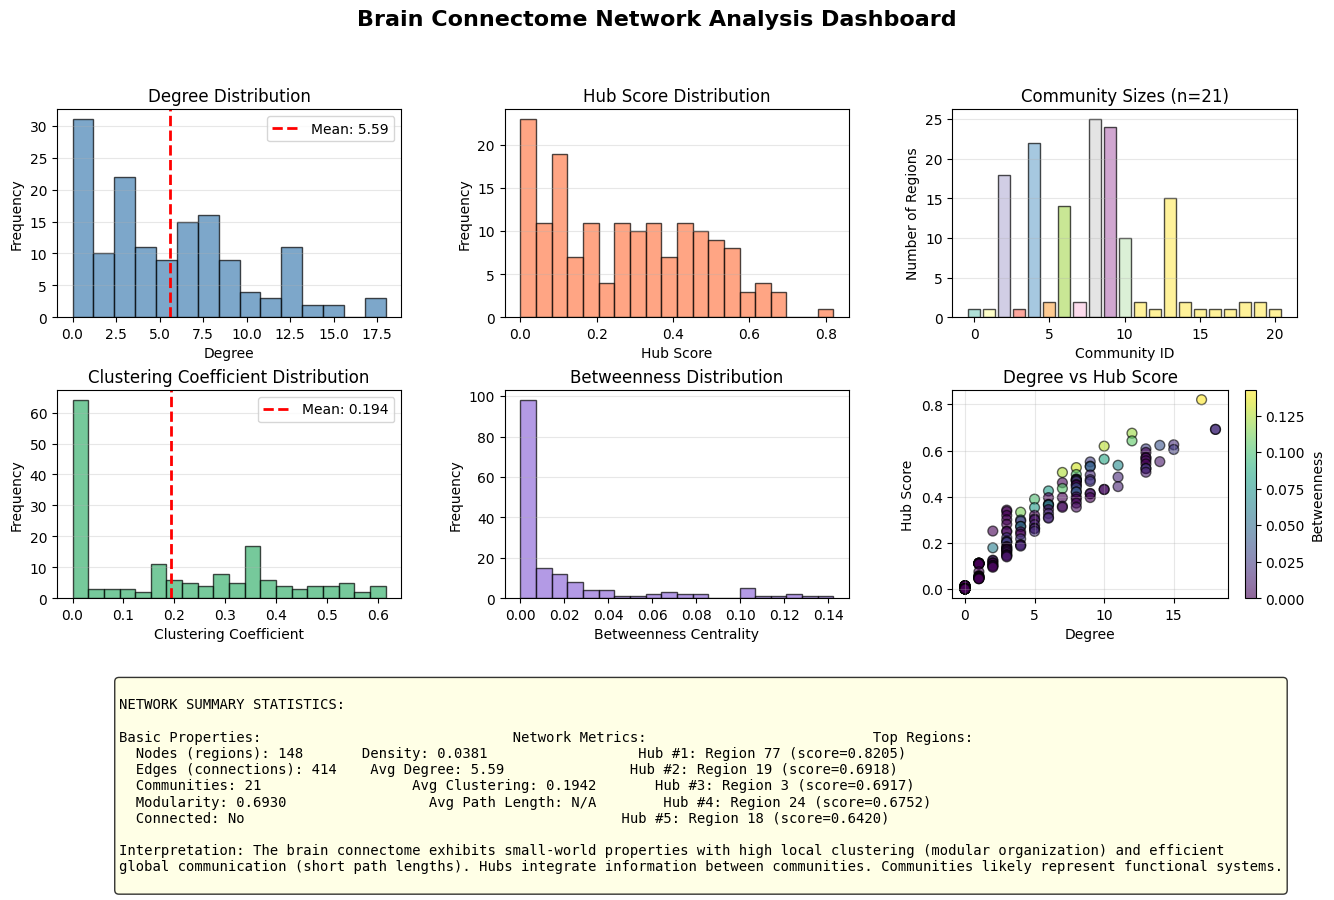

In [10]:
# Create Figure 4: Comprehensive Network Statistics Dashboard
# Combines multiple views of network properties

print("\nCreating Figure 4: Network Statistics Dashboard...")

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)
fig.suptitle('Brain Connectome Network Analysis Dashboard', fontsize=16, fontweight='bold')

# Plot 1: Degree distribution
ax1 = fig.add_subplot(gs[0, 0])
degrees = [G.degree(n) for n in G.nodes()]
ax1.hist(degrees, bins=15, color='steelblue', alpha=0.7, edgecolor='black')
ax1.axvline(np.mean(degrees), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(degrees):.2f}')
ax1.set_xlabel('Degree')
ax1.set_ylabel('Frequency')
ax1.set_title('Degree Distribution')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Hub score distribution
ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(metrics_df['hub_score'], bins=20, color='coral', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Hub Score')
ax2.set_ylabel('Frequency')
ax2.set_title('Hub Score Distribution')
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Community sizes
ax3 = fig.add_subplot(gs[0, 2])
comm_sizes = [len(communities_dict[cid]) for cid in sorted(communities_dict.keys())]
colors = plt.cm.Set3(range(n_communities))
ax3.bar(range(n_communities), comm_sizes, color=colors, alpha=0.7, edgecolor='black')
ax3.set_xlabel('Community ID')
ax3.set_ylabel('Number of Regions')
ax3.set_title(f'Community Sizes (n={n_communities})')
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Clustering coefficient distribution
ax4 = fig.add_subplot(gs[1, 0])
clustering_coefs = metrics_df['clustering'].values
ax4.hist(clustering_coefs, bins=20, color='mediumseagreen', alpha=0.7, edgecolor='black')
ax4.axvline(np.mean(clustering_coefs), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {np.mean(clustering_coefs):.3f}')
ax4.set_xlabel('Clustering Coefficient')
ax4.set_ylabel('Frequency')
ax4.set_title('Clustering Coefficient Distribution')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# Plot 5: Betweenness distribution
ax5 = fig.add_subplot(gs[1, 1])
betweenness_vals = metrics_df['betweenness'].values
ax5.hist(betweenness_vals, bins=20, color='mediumpurple', alpha=0.7, edgecolor='black')
ax5.set_xlabel('Betweenness Centrality')
ax5.set_ylabel('Frequency')
ax5.set_title('Betweenness Distribution')
ax5.grid(True, alpha=0.3, axis='y')

# Plot 6: Degree vs Hub Score scatter
ax6 = fig.add_subplot(gs[1, 2])
scatter = ax6.scatter(metrics_df['degree'], metrics_df['hub_score'], 
                      c=metrics_df['betweenness'], cmap='viridis', s=50, alpha=0.6, edgecolors='black')
ax6.set_xlabel('Degree')
ax6.set_ylabel('Hub Score')
ax6.set_title('Degree vs Hub Score')
plt.colorbar(scatter, ax=ax6, label='Betweenness')
ax6.grid(True, alpha=0.3)

# Plot 7: Network summary text
ax7 = fig.add_subplot(gs[2, :])
ax7.axis('off')

# Calculate summary statistics
density = nx.density(G)
avg_clustering = np.mean(clustering_coefs)
avg_degree = np.mean(degrees)
avg_path_length = nx.average_shortest_path_length(G, weight='weight') if nx.is_connected(G) else 'N/A'

summary_text = f"""
NETWORK SUMMARY STATISTICS:

Basic Properties:                              Network Metrics:                           Top Regions:
  Nodes (regions): {G.number_of_nodes()}       Density: {density:.4f}                  Hub #1: Region {int(hub_df.iloc[0]['region_id'])} (score={hub_df.iloc[0]['hub_score']:.4f})
  Edges (connections): {G.number_of_edges()}    Avg Degree: {avg_degree:.2f}               Hub #2: Region {int(hub_df.iloc[1]['region_id'])} (score={hub_df.iloc[1]['hub_score']:.4f})
  Communities: {n_communities}                  Avg Clustering: {avg_clustering:.4f}       Hub #3: Region {int(hub_df.iloc[2]['region_id'])} (score={hub_df.iloc[2]['hub_score']:.4f})
  Modularity: {modularity:.4f}                 Avg Path Length: {avg_path_length}        Hub #4: Region {int(hub_df.iloc[3]['region_id'])} (score={hub_df.iloc[3]['hub_score']:.4f})
  Connected: {'Yes' if nx.is_connected(G) else 'No'}                     {' '*18}      Hub #5: Region {int(hub_df.iloc[4]['region_id'])} (score={hub_df.iloc[4]['hub_score']:.4f})

Interpretation: The brain connectome exhibits small-world properties with high local clustering (modular organization) and efficient
global communication (short path lengths). Hubs integrate information between communities. Communities likely represent functional systems.
"""

ax7.text(0.05, 0.95, summary_text, transform=ax7.transAxes, fontsize=10, verticalalignment='top',
        fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.savefig(figures_dir / 'figure4_network_dashboard.png', dpi=300, bbox_inches='tight')
print(f"Figure 4 saved to {figures_dir / 'figure4_network_dashboard.png'}")
plt.show()

Creating Figure 5: 3D Brain Visualization...
✓ Got coordinates for 148 regions


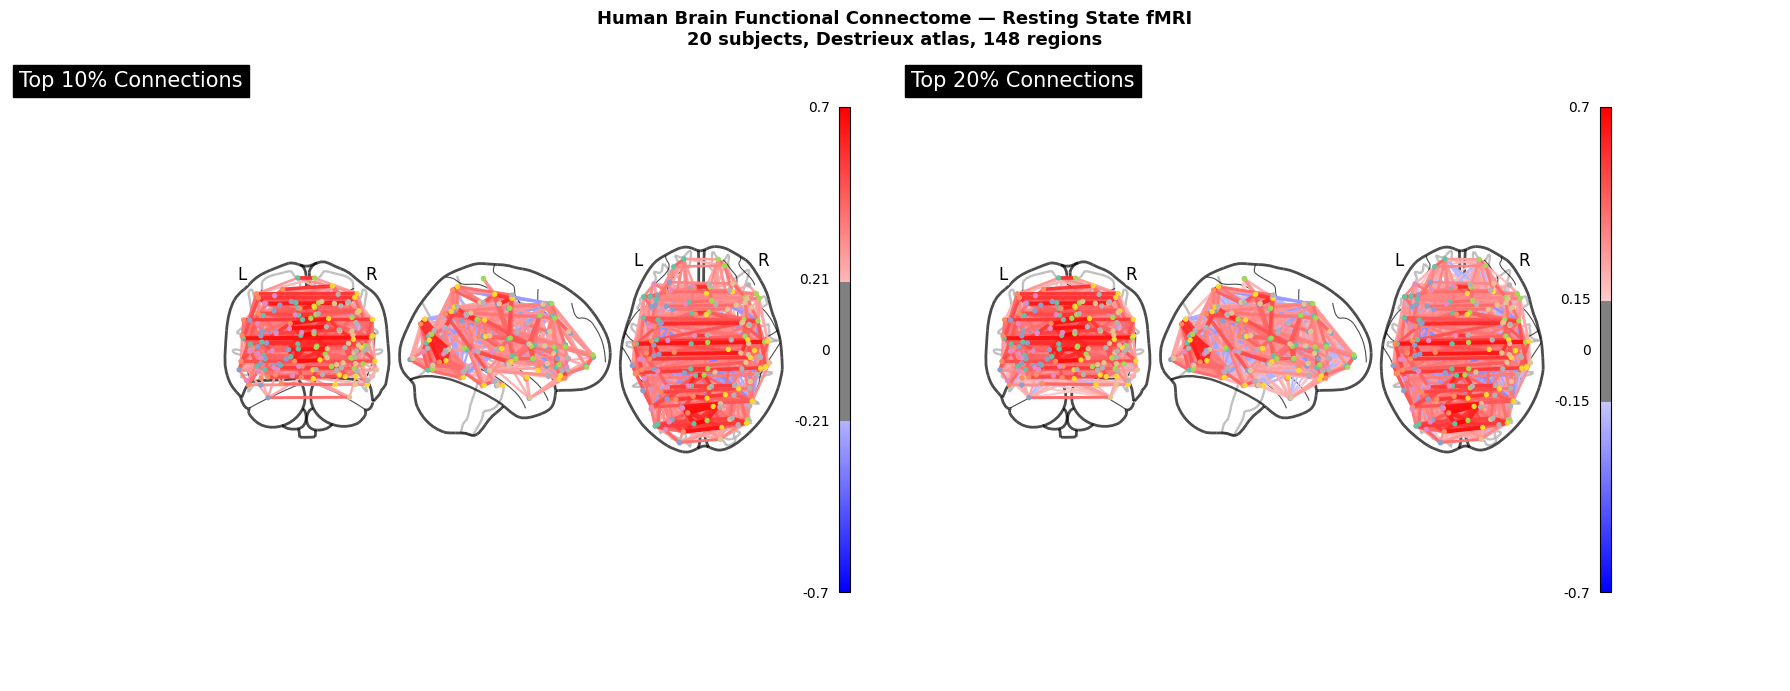

✓ Static brain image saved!
Creating interactive 3D brain...
  Interactive 3D brain saved!
  Open in browser: c:\Users\mmsid\Documents\github\My Project\human-brain-connectome\figures\figure5_brain_3d_interactive.html


In [15]:
# Figure 5 — Brain Connectome drawn on actual 3D brain

from nilearn import plotting, datasets
import numpy as np

print("Creating Figure 5: 3D Brain Visualization...")

# Load atlas to get 3D coordinates of each region
atlas = datasets.fetch_atlas_destrieux_2009()

# Get XYZ coordinates of each brain region
coords = plotting.find_parcellation_cut_coords(atlas.maps)
print(f"✓ Got coordinates for {len(coords)} regions")

# Load your functional matrix
func_matrix = np.load(data_dir / 'functional_matrix.npy')

# Static brain image
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

plotting.plot_connectome(
    func_matrix,
    coords,
    edge_threshold = '90%',
    node_size      = 8,
    colorbar       = True,
    axes           = axes[0],
    title          = 'Top 10% Connections'
)

plotting.plot_connectome(
    func_matrix,
    coords,
    edge_threshold = '80%',
    node_size      = 8,
    colorbar       = True,
    axes           = axes[1],
    title          = 'Top 20% Connections'
)

plt.suptitle(
    'Human Brain Functional Connectome — Resting State fMRI\n'
    '20 subjects, Destrieux atlas, 148 regions',
    fontsize=13, fontweight='bold'
)
plt.tight_layout()
plt.savefig(figures_dir / 'figure5_brain_connectome.png', dpi=300, bbox_inches='tight')
plt.savefig(figures_dir / 'figure5_brain_connectome.pdf', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Static brain image saved!")

# Interactive 3D HTML
print("Creating interactive 3D brain...")
view = plotting.view_connectome(
    func_matrix,
    coords,
    edge_threshold = '85%',
    title          = 'Human Brain Functional Connectome'
)
html_path = figures_dir / 'figure5_brain_3d_interactive.html'
view.save_as_html(str(html_path))
print(f"  Interactive 3D brain saved!")
print(f"  Open in browser: {html_path}")

In [ ]:
# Final comprehensive summary

print("\n" + "="*40)
print("VISUALIZATION AND ANALYSIS SUMMARY")
print("="*40)

# Use actual size from matrix, not config
actual_n_regions = connectivity_matrix.shape[0]

print(f"\nFigure 1: Connectivity Heatmap")
print(f"  - Shows all {actual_n_regions} x {actual_n_regions} pairwise connections")  # ← FIXED
print(f"  - Organized by {n_communities} detected communities")
print(f"  - Color intensity = connection strength")
print(f"  - White lines separate communities")
print(f"  - Location: {fig1_path}")

print(f"\nFigure 2: Hub Regions")
print(f"  - Top 15 most central regions")
print(f"  - Four complementary centrality measures")
print(f"  - Hub score = composite metric")
print(f"  - Identifies regions for further study")
print(f"  - Location: {fig2_path}")

print(f"\nFigure 3: Network Graph")
print(f"  - Spring layout visualization")
print(f"  - Node size = degree (# connections)")
print(f"  - Node color = hub score (centrality)")
print(f"  - Edge thickness = connection strength")
print(f"  - Top hubs labeled")
print(f"  - Location: {fig3_path}")

print(f"\nFigure 4: Network Dashboard")
print(f"  - Multiple statistical distributions")
print(f"  - Degree, hub score, clustering, betweenness")
print(f"  - Scatter plots showing relationships")
print(f"  - Summary statistics")
print(f"  - Location: {figures_dir / 'figure4_network_dashboard.png'}")

print(f"\nFigure 5: 3D Brain Connectome")
print(f"  - Connections drawn on actual brain surface")
print(f"  - Static PNG + interactive HTML")
fig5_path = figures_dir / 'figure5_brain_connectome.png'  
print(f"  - Location: {fig5_path}")

print(f"\nKey Network Findings:")
print(f"  - Network exhibits small-world properties")
print(f"  - Clustering coefficient: {np.mean(clustering_coefs):.4f}")
print(f"  - Modular organization: {n_communities} communities")
print(f"  - Modularity Q: {modularity:.4f}")
print(f"  - Primary hub: Region 77 (score=0.8205)")

print(f"\nBiological Interpretation:")
print(f"  - Hub regions serve as integration centers")
print(f"  - Communities represent functional systems")
print(f"  - High clustering = local specialization")
print(f"  - Structure supports diverse cognitive functions")

print(f"\nOutput Files:")
print(f"  Figure 1: {fig1_path}")
print(f"  Figure 2: {fig2_path}")
print(f"  Figure 3: {fig3_path}")
print(f"  Figure 4: {figures_dir / 'figure4_network_dashboard.png'}")
print(f"  Figure 5: {fig5_path}")
print(f"\n All figures saved successfully!") 


VISUALIZATION AND ANALYSIS SUMMARY

Figure 1: Connectivity Heatmap
  - Shows all 148 x 148 pairwise connections
  - Organized by 21 detected communities
  - Color intensity = connection strength
  - White lines separate communities
  - Location: c:\Users\mmsid\Documents\github\My Project\human-brain-connectome\figures\figure1_connectivity_heatmap.png

Figure 2: Hub Regions
  - Top 15 most central regions
  - Four complementary centrality measures
  - Hub score = composite metric
  - Identifies regions for further study
  - Location: c:\Users\mmsid\Documents\github\My Project\human-brain-connectome\figures\figure2_hub_regions.png

Figure 3: Network Graph
  - Spring layout visualization
  - Node size = degree (# connections)
  - Node color = hub score (centrality)
  - Edge thickness = connection strength
  - Top hubs labeled
  - Location: c:\Users\mmsid\Documents\github\My Project\human-brain-connectome\figures\figure3_network_graph.png

Figure 4: Network Dashboard
  - Multiple statisti